In [1]:
import sys
sys.path.append('../..')

In [2]:
import os
import psutil

import random
import math
from functools import partial

import torch 
from torch import optim
from torch.optim import lr_scheduler
from torch import nn
from torch.nn import functional as F

import multiprocessing.dummy as mp

from pytorch_lightning import Trainer
from pytorch_lightning.core import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger


from lib.schedulers import DelayedScheduler
from lib.datasets import (max_lbl_nums, actual_lbl_nums, 
                          patches_rgb_mean_av1, patches_rgb_std_av1, 
                          get_train_test_img_ids_split)
from lib.dataloaders import PatchesDataset, WSIPatchesDatasetRaw, WSIPatchesDummyDataloader
from lib.augmentations import augment_v1_clr_only, augment_empty_clr_only
from lib.losses import SmoothLoss
from lib.trainers import WSIModuleV1

from lib.models.unetv1 import get_model
from lib.models.features_map import FeaturesMap

from sklearn.metrics import cohen_kappa_score

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [3]:
# import cv2
import numpy as np
# import pandas as pd
# from lib.datasets import patches_csv_path, patches_path
from lib.datasets import (patches_clean90_csv_path as patches_csv_path, patches_path,
                          patches_clean90_pkl_path as patches_pkl_path)
# from lib.dataloaders import imread, get_g_score_num, get_provider_num

In [4]:
train_img_ids, test_img_ids = get_train_test_img_ids_split()

test_img_ids[:4]

['e8baa3bb9dcfb9cef5ca599d62bb8046',
 '9b2948ff81b64677a1a152a1532c1a50',
 '5b003d43ec0ce5979062442486f84cf7',
 '375b2c9501320b35ceb638a3274812aa']

In [5]:
from lib.dataloaders import WSIPatchesDataloader, WSIPatchesDatasetRaw
from lib.utils import get_pretrained_model, get_features

In [6]:
main_batch_size = 64

In [7]:
train_batch_path = '/mnt/HDDData/pdata/processed/pretrained_64x8x8/train/{}/'
test_batch_path = '/mnt/HDDData/pdata/processed/pretrained_64x8x8/val/'

train_loader = WSIPatchesDummyDataloader(train_batch_path, precalc_epochs=32, shuffle=True)
val_loader = WSIPatchesDummyDataloader(test_batch_path, precalc_epochs=32, shuffle=False)

In [8]:
steps_in_epoh = 1

epochs = 90

warmup_epochs = 0
warmup_steps = 0
batch_size = 64

hparams = {
    'module': {
        'name': 'lib.trainers.WSIModuleV1',
        'params': {
            'model': {
                'name': 'lib.models.wsi_resnets.Resnet_512x1x1',
                'params': {
                    'backbone': 'resnet18',
                    'backbone_features': 512,
                    'classes': max_lbl_nums,
                    'features_do': 0,
                }
            },
        },
    },
    'batch_size': batch_size,
    'learning_rate': 0.001 * batch_size / 256,
    'dataset': {
        'dataloader': 'dummy',
        'rgb_mean': patches_rgb_mean_av1,
        'rgb_std': patches_rgb_std_av1,
        'classes': max_lbl_nums,
        'precalc_epochs': 50,
        'train_test_split': {},
    },
    'optimizer': {
        'name': 'torch.optim.Adam',
        'params': {
            'weight_decay': 1e-4
        }
    },
    'scheduler': {
        'name': 'lib.schedulers.ExponentialLRWithMin',
        'params': {
            'gamma': 0.92,
            'eta_min': 1.25e-5
        },
        'interval': 'epoch'
    },
    'loss': {
        'weights': {
            'reg': 1 / 2,
            'class': 9 / 2
        },
        'label_smoothing': 0.1
    },
    'warmup_steps': warmup_steps,
    'steps_in_epoh': steps_in_epoh,
    'epochs': epochs
}

In [9]:
steps_in_epoh = len(train_loader)

In [10]:
steps_in_epoh

132

In [11]:
hparams['steps_in_batch'] = steps_in_epoh
if 'T_max' in hparams['scheduler']['params']:
    hparams['scheduler']['params']['T_max'] = (epochs * steps_in_epoh -
                                               warmup_steps)

In [12]:
# tmp[0].shape
# torch.Size([64, 300, 64, 8, 8])

In [13]:
class FeaturesMap(nn.Module):
    def __init__(self, use_dummy_feature, f_channels=512, max_height=70,
                 max_width=40, f_size=1):
        super().__init__()
        
        self.f_size = f_size
        self.max_height = max_height * self.f_size
        self.max_width = max_width * self.f_size
        self.f_channels = f_channels
        self.use_dummy_feature = use_dummy_feature
        
        if self.use_dummy_feature:
            self.backend_feature =\
                nn.Parameter(torch.full((self.f_channels, 1, 1), 0))

    def forward(self, features, ys, xs, validation=None):
        if validation is None:
            validation = not self.training

        b_sz = features.shape[0]

        if self.use_dummy_feature:
            f_map = self.backend_feature.expand(self.f_channels,
                                                self.max_height,
                                                self.max_width)
        else:
            f_map = torch.full((self.f_channels, self.max_height,
                                self.max_width), 0,
                               dtype=features.dtype, device=features.device)

        res_f_maps = []
        for b in range(b_sz):
            real_mask = ys[b] > -1

            min_y, max_y = (ys[b, real_mask].min().item(),
                            ys[b, real_mask].max().item())
            min_x, max_x = (xs[b, real_mask].min().item(),
                            xs[b, real_mask].max().item())
            
            height = (max_y - min_y + 1) * self.f_size
            width = (max_x - min_x + 1) * self.f_size

            tmp_f_map = torch.full((self.f_channels, height, width), -1,
                                   dtype=features.dtype,
                                   device=features.device)

            if self.f_size == 1:
                tmp_f_map[:, ys[b, real_mask] - min_y, xs[b, real_mask] - min_x] =\
                    features[b, :, real_mask]
            else:
                for n in range(real_mask.sum().item()):
                    t = features[b, n]
                    _y = ys[b, n] - min_y
                    _x = xs[b, n] - min_x                    
                    tmp_f_map[:, _y*self.f_size:(_y+1)*self.f_size, 
                                 _x*self.f_size:(_x+1)*self.f_size] = t

            if width > height:
                tmp_f_map = tmp_f_map.transpose(-1, -2)

            _, height, width = tmp_f_map.shape
            # print(height, width)

            h_dif = height - self.max_height
            w_dif = width - self.max_width

            if h_dif > 0:
                cut_top = (math.ceil(h_dif / 2) if validation else
                           random.randint(0, h_dif))
                cut_bottom = -(h_dif - cut_top)
                if cut_bottom >= 0:
                    cut_bottom = None
                pad_top, pad_bottom = 0, 0
            else:
                pad_top = (math.ceil(-h_dif / 2) if validation else
                           random.randint(0, -h_dif))
                pad_bottom = -h_dif - pad_top
                cut_top, cut_bottom = 0, None

            if w_dif > 0:
                cut_left = (math.ceil(w_dif / 2) if validation else
                            random.randint(0, w_dif))
                cut_right = -(w_dif - cut_left)
                if cut_right >= 0:
                    cut_right = None
                pad_right, pad_left = 0, 0
            else:
                pad_right = (math.ceil(-w_dif / 2) if validation else
                             random.randint(0, -w_dif))
                pad_left = -w_dif - pad_right
                cut_left, cut_right = 0, None

            if not validation:
                if random.random() > 0.5:
                    tmp_f_map = torch.flip(tmp_f_map, [-1])

                if random.random() > 0.5:
                    tmp_f_map = torch.flip(tmp_f_map, [-2])

            tmp_f_map = F.pad(tmp_f_map[:, cut_top:cut_bottom,
                                        cut_left:cut_right],
                              (pad_right, pad_left,
                               pad_top, pad_bottom), value=-1)

            real_2d_mask = (tmp_f_map != -1).all(dim=0)

            # print(real_2d_mask.shape, f_map.shape, tmp_f_map.shape)

            res_f_map = (~real_2d_mask) * f_map + real_2d_mask * tmp_f_map
            res_f_maps.append(res_f_map)

        return torch.stack(res_f_maps)

In [14]:
features, ys, xs, provider, isup_grade, gleason_score = next(iter(train_loader))

In [15]:
features.shape

torch.Size([64, 300, 64, 8, 8])

In [16]:
# f_map = FeaturesMap(False, 64, 70, 40, f_size=8)

In [17]:
self = lambda x: x

In [18]:
self.t_size = 8

In [19]:
%%time

s_features = []
all_cnt = (ys > -1).sum()*self.t_size*self.t_size
# all_cnt = (ys[:2] > -1).sum()*self.t_size*self.t_size
s_coords = torch.zeros((all_cnt, 3), dtype=torch.int32)
cnt = 0
for b in range(ys.shape[0]):
# for b in range(2):
    y_min = ys[b].min()
    x_min = xs[b].min()    
    for n in range(ys.shape[1]):
        if ys[b, n] > -1:
            for p_y in range(self.t_size):
                for p_x in range(self.t_size):  
                    s_coords[cnt, 0] = b
                    s_coords[cnt, 1] = (ys[b, n]-y_min)*self.t_size + p_y
                    s_coords[cnt, 2] = (xs[b, n]-x_min)*self.t_size + p_x
                    s_features.append(features[b, n, :, p_y, p_x])
                    cnt += 1
                    
s_features = torch.stack(s_features)

CPU times: user 22.2 s, sys: 123 ms, total: 22.3 s
Wall time: 22.3 s


In [20]:
device = torch.device('cuda:0')

In [21]:
# features, ys, xs = features.to(device), ys.to(device), xs.to(device)

In [22]:
s_features, s_coords = s_features.to(device), s_coords.to(device)

In [23]:
import spconv

In [24]:
s_coords[:, 1].max(), s_coords[:, 2].max()

(tensor(599, device='cuda:0', dtype=torch.int32),
 tensor(495, device='cuda:0', dtype=torch.int32))

In [25]:
spatial_shape = (640, 640)

In [26]:
batch_size = 64

In [27]:
x = spconv.SparseConvTensor(s_features, s_coords, spatial_shape, batch_size)

In [28]:
s_conv = spconv.SparseConv2d(64, 64, 3, use_hash=False).to(device)

In [29]:
tmp = s_conv(x)

In [30]:
tmp = s_conv(tmp)

In [31]:
tmp = s_conv(tmp)

In [32]:
tmp = s_conv(tmp)

In [34]:
s_pool = spconv.SparseMaxPool2d(2)

In [38]:
tmp = s_pool(tmp)

In [ ]:
x_dense_NCHW = tmp.dense()

In [79]:
x_dense_NCHW.shape

torch.Size([2, 64, 718, 718])

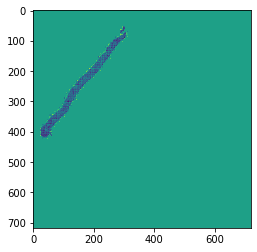

In [82]:
plt.imshow(x_dense_NCHW[0, 0].detach());

In [105]:
x_dense_NCHW[1].sum()

tensor(35.8602)

In [ ]:
features = # your features with shape [N, numPlanes]
indices = # your indices/coordinates with shape [N, ndim + 1], batch index must be put in indices[:, 0]
spatial_shape = # spatial shape of your sparse tensor.
batch_size = # batch size of your sparse tensor.
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)
x_dense_NCHW = x.dense() # convert sparse tensor to dense NCHW tensor.
print(x.sparity) # helper function to check sparity. 

In [21]:
from mmdet.ops import MaskedConv2d

In [22]:
class StackMaskedConv2d(MaskedConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, 
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 
                         padding, dilation, groups, bias)

    def forward(self, x, masks):
        out = []
        for b in range(x.shape[0]):
            out.append(super().forward(x[b][None, ...], masks[b][None, ...]))
        return torch.cat(out, dim=0)

In [23]:
m_conv = StackMaskedConv2d(64, 64, 3).to(device)

In [26]:
x_masks = ~(x_map == 0).all(dim=1)

In [29]:
tmp = m_conv(x_map, x_masks)

/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addmm is deprecated:
	addmm(Number beta, Tensor input, Number alpha, Tensor mat1, Tensor mat2, *, Tensor out)
Consider using one of the following signatures instead:
	addmm(Tensor input, Tensor mat1, Tensor mat2, *, Number beta, Number alpha, Tensor out)


In [30]:
tmp.shape

torch.Size([64, 64, 558, 318])

In [34]:
x_masks = ~(tmp == 0).all(dim=1)

In [35]:
tmp2 = m_conv(tmp, x_masks)

RuntimeError: CUDA out of memory. Tried to allocate 2.68 GiB (GPU 1; 10.92 GiB total capacity; 8.45 GiB already allocated; 1.84 GiB free; 8.55 GiB reserved in total by PyTorch)

torch.Size([64, 64, 560, 320])

In [14]:
import torchvision.models as models

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)

f_d_rate = 0.0
d_rate = 0.0

max_height = 70
max_width = 40

class MainModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.f_map = FeaturesMap(False, 64, max_height, max_width, f_size=8)
        
        # self.backbone = models.resnext50_32x4d(pretrained=False)
        self.backbone = models.resnet18(pretrained=False)
        '''
        self.backbone.conv1 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 1),
        )
        '''
        self.backbone.conv1 = nn.Identity()
        # self.backbone.fc = nn.Linear(2048, 512)
        self.backbone.fc = nn.Linear(512, 512)
        self.backbone.maxpool = nn.Identity()
        
        self.reg_linear = nn.Linear(512, 1)
        self.class_linear = nn.Linear(512, max_lbl_nums)

    def forward(self, features, ys, xs):
        f_map = self.f_map(features, ys, xs)
        x = self.backbone(f_map)
        return self.reg_linear(x), self.class_linear(x)

model = MainModel()

In [15]:
# model.backbone

In [16]:
#from torchsummary import summary

In [17]:
#summary(model.backbone, (64, 70*8, 40*8), device='cpu')

In [18]:
module = WSIModuleV1(model, hparams, log_train_every_batch=False)

In [19]:
trainer = Trainer(max_epochs=hparams['epochs'], gpus=[1,], fast_dev_run=False, num_sanity_val_steps=0)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [1]


In [20]:
trainer.fit(module, train_loader, val_loader)
trainer.save_checkpoint(os.path.join(trainer.checkpoint_callback.dirpath,
                                     "last.ckpt"))

INFO:lightning:
   | Name                                 | Type              | Params
-----------------------------------------------------------------------
0  | model                                | MainModel         | 11 M  
1  | model.f_map                          | FeaturesMap       | 0     
2  | model.backbone                       | ResNet            | 11 M  
3  | model.backbone.conv1                 | Identity          | 0     
4  | model.backbone.bn1                   | BatchNorm2d       | 128   
5  | model.backbone.relu                  | ReLU              | 0     
6  | model.backbone.maxpool               | Identity          | 0     
7  | model.backbone.layer1                | Sequential        | 147 K 
8  | model.backbone.layer1.0              | BasicBlock        | 73 K  
9  | model.backbone.layer1.0.conv1        | Conv2d            | 36 K  
10 | model.backbone.layer1.0.bn1          | BatchNorm2d       | 128   
11 | model.backbone.layer1.0.relu         | ReLU            

[Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.00025
    lr: 0.00025
    weight_decay: 0.0001
)] [{'interval': 'epoch', 'scheduler': <lib.schedulers.DelayedScheduler object at 0x7fd8066486d0>}]


/home/ruslan/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


/home/ruslan/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2247: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...
